# Music Genre Classification by Kelan Morgan
Data received from https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
# Library's

In [22]:
import os
import pandas as pd
import librosa
import numpy as np

# Import the data
drop all rows that are not file name and label

In [14]:
data = pd.read_csv("Data/features_30_sec.csv")
data = data[['filename', 'label']]

# Function to extract audio data
extract:
- Tempo: speed of the song in Beats Per Minute
- MFCCs: Gets characteristics of the audio (instruments)
- Chroma: Pitch
- Spectral Centroid: Brightness of the sound
- Zero-Crossing Rate: Noisiness of the sound
- RMS Energy: Loudness or intensity of the audio

https://librosa.org/doc/latest/feature.html#spectral-features

In [15]:
def extract_features(file_path):
    #load the audio files first 30 seconds
    y, sr = librosa.load(file_path, duration=30)

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms_energy = librosa.feature.rms(y=y)

    # get the average of each piece of audio data
    features = {
        'tempo': tempo,
        'mfccs': mfccs.mean(axis=1),
        'chroma': chroma.mean(axis=1),
        'spectral_centroid': spectral_centroid.mean(),
        'zero_crossing_rate': zero_crossing_rate.mean(),
        'rms_energy': rms_energy.mean()
    }
    return features

# function to Load audio file

In [16]:
def load_data(base_directory):
    data = []
    for genre in os.listdir(base_directory):
        genre_dir = os.path.join(base_directory, genre)
        if os.path.isdir(genre_dir):  # Ensure it's a directory
            for file_name in os.listdir(genre_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(genre_dir, file_name)
                    try:
                        features = extract_features(file_path)
                        features['filename'] = file_name
                        features['label'] = genre  # Add genre label
                        data.append(features)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(data)

# Process the data

In [17]:
from sklearn.preprocessing import StandardScaler

data = load_data("Data/genres_original")

# Combine MFCCs and chroma into one
data['mfccs'] = data['mfccs'].apply(lambda x: x.tolist())
data['chroma'] = data['chroma'].apply(lambda x: x.tolist())

# Create a feature matrix
feature_matrix = np.hstack([
    data['tempo'].values.reshape(-1, 1),
    np.vstack(data['mfccs'].values),
    np.vstack(data['chroma'].values),
    data['spectral_centroid'].values.reshape(-1, 1),
    data['zero_crossing_rate'].values.reshape(-1, 1),
    data['rms_energy'].values.reshape(-1, 1)
])

# Normalize the feature matrix
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)

# Apply the k-means clustering

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=6)
clusters = kmeans.fit_predict(feature_matrix)

data["clusters"] = clusters

# Visualize clusters

Text(0.5, 1.0, 'Music Genre Clusters')

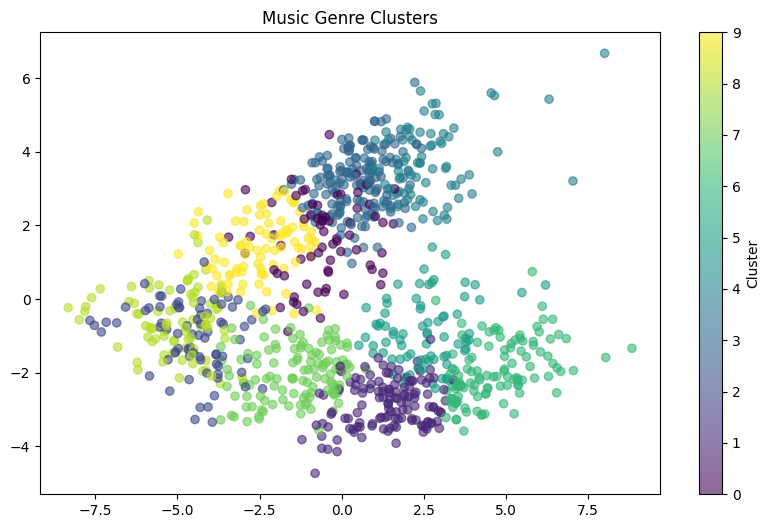

In [27]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Reduce size to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data['clusters'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Music Genre Clusters")